# Introduction

We are building a machine learning pipeline for classification of EEG signals.

Preprocessing files will be run separetely from this notebook, and we will import their variables.

This notebook will focus on creating the pipeline for assessing the best model to detect seizures in EEG signals. We will use three main strategies:

* Res2Net Transformer
* 1D-CNN + LSTM 
* Gated 2 Tower Transformer 

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import lightning.pytorch as pl
import pickle
import copy
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

print(torch.cuda.is_available())
print(torch.__version__)


plt.style.use("ggplot")

True
2.0.0+cu118


# Importing and Preprocessing Data

In [2]:
%run ./preprocessing.py

In [3]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
y_test = torch.FloatTensor(y_test).unsqueeze(1)
y_val = torch.FloatTensor(y_val).unsqueeze(1)

In [4]:
y_train.unique(return_counts=True)

(tensor([0., 1.]), tensor([6440, 1610]))

In [5]:
class EEGDataset(Dataset):
    def __init__(self, features, target) -> None:
        super().__init__()
        self.features = features
        self.target = target

    def __getitem__(self, index):
        data = {}
        features = self.features[index]
        target = self.target[index]
        data["X"] = features
        data["y"] = target
        return data

    def __len__(self):
        return len(self.features)


BATCH_SIZE = 32
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 75
LEARNING_RATE = 1e-4
train_dataloader = DataLoader(EEGDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(EEGDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
final_train_dataloader = DataLoader(EEGDataset(torch.cat((X_train, X_val), 0), torch.cat((y_train, y_val), 0)), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(EEGDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# Creating Models

## Training code

In [6]:


def training(
        model, train_dataloader=None, val_dataloader=None,
        epochs=5, lr=0.001, device='cpu', earlystopping_tolerance=5):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([9200/2300]).to(device))
    # criterion = nn.BCELoss()
    model_state = {
        "model": None,
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
    }
    best_validation = np.inf
    best_accuracy = -np.inf
    best_model = None
    count_tolerance = 0


    for epoch in range(epochs):
        training_loss = 0

        val_predictions = []
        val_groundtruth = []
        for i, data in enumerate(train_dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            X, y = data["X"].to(device), data["y"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(X)
            train_loss = criterion(outputs, y)
            train_loss.backward()
            optimizer.step()

            # print statistics
            training_loss += train_loss.item()
        
        training_loss /= i
        
        if isinstance(val_dataloader, DataLoader):
            validation_loss = 0
            for j, data in enumerate(val_dataloader, 1):
                # get the inputs; data is a list of [inputs, labels]
                X, y = data["X"].to(device), data["y"].to(device)
                val_groundtruth.append(y)

                # forward + backward + optimize
                with torch.no_grad():
                    outputs = model(X)
                    val_predictions.append(torch.sigmoid(outputs))
                    val_loss = criterion(outputs, y)
                    
                    # print statistics
                    validation_loss += val_loss.item()
            val_groundtruth = torch.cat(val_groundtruth, axis=0).cpu().squeeze(-1).detach().numpy()
            val_predictions = torch.cat(val_predictions, axis=0).cpu().squeeze(-1).detach().numpy()
            val_predictions = (val_predictions > 0.5).astype(np.int16)
            val_acc = accuracy_score(val_groundtruth, val_predictions)
            val_precision = precision_score(val_groundtruth, val_predictions)
            val_recall = recall_score(val_groundtruth, val_predictions)
            val_f1 = f1_score(val_groundtruth, val_predictions)

            validation_loss /= j
            scheduler.step(validation_loss)
            # if (validation_loss) < best_validation:
            if val_acc > best_accuracy:
                count_tolerance = 0
                best_validation = validation_loss
                best_accuracy = val_acc
                best_model = copy.deepcopy(model)
            
            count_tolerance += 1
            print(f"Epoch: {epoch}\tTraining loss: {training_loss:.5f}\t\t Validation Loss: {validation_loss:.5f}\tValidation Accuracy: {val_acc:.5f}")
            model_state["train_loss"].append(training_loss)
            model_state["val_loss"].append(validation_loss)
            model_state["val_acc"].append(val_acc)
            model_state["val_precision"].append(val_precision)
            model_state["val_recall"].append(val_recall)
            model_state["val_f1"].append(val_f1)

            if count_tolerance >= earlystopping_tolerance:
                break
            
        else:
            print(f"Epoch: {epoch}\tTraining loss: {training_loss:.5f}")
            model_state["train_loss"].append(training_loss)
            best_model = copy.deepcopy(model)
        
    
    model_state["model"] = best_model
    save_model(model_state)
    torch.cuda.empty_cache()
    return model_state, best_model

def save_model(model_state):
    with open(f"models/{ model_state['model'].to_string() }.pkl", "wb") as fp:
        model_state["model"] = model_state["model"].to("cpu").state_dict()
        pickle.dump(model_state, fp)
        print("Saved model successfully!")

# def test_accuracy_score(model, test_dataloader):
#     y_pred = 

## 1D CNN-LSTM Model

In [7]:
class CNN_LSTM_Classifier(pl.LightningModule):
    def __init__(self,):
        super().__init__()
        self.device_ = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.conv_1 = nn.Conv1d(1, 64, 3)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool1d(2, 2)
        self.conv_layers = nn.Sequential(
            nn.Conv1d(64, 128, 3),
            nn.ReLU(),
            nn.Conv1d(128, 512, 3),
            nn.ReLU(),
            nn.Conv1d(512, 1024, 3),
            nn.ReLU()
        )
        self.flatten_layer = nn.Linear(82, 256)
        dropout = 0.2
        self.dropout = nn.Dropout(dropout)

        self.lstm = nn.LSTM(1024, 64, 2, batch_first=True, dropout=dropout)

        self.fc_out = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )


    def forward(self, X: torch.FloatTensor, y=None):
        X = X.transpose(1, 2)
        out = self.relu(self.conv_1(X))
        out = self.max_pool(out)
        out = self.conv_layers(out)
        out = self.flatten_layer(out)
        out = out.transpose(1, 2)
        out, (_, _) = self.lstm(out)
        out = out[:, -1, :]
        out = self.fc_out(out)
        return out
    
    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred

    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return "CNN_LSTM_Classifier"


    
model_cnn_lstm = CNN_LSTM_Classifier()
state_cnn_lstm, model_cnn_lstm = training(model_cnn_lstm, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)

Epoch: 0	Training loss: 1.11038		 Validation Loss: 1.10710	Validation Accuracy: 0.19942
Epoch: 1	Training loss: 1.03097		 Validation Loss: 0.86291	Validation Accuracy: 0.72232
Epoch: 2	Training loss: 0.74802		 Validation Loss: 0.57889	Validation Accuracy: 0.87420
Epoch: 3	Training loss: 0.55070		 Validation Loss: 0.44695	Validation Accuracy: 0.86899
Epoch: 4	Training loss: 0.44110		 Validation Loss: 0.38365	Validation Accuracy: 0.92638
Epoch: 5	Training loss: 0.39934		 Validation Loss: 0.31732	Validation Accuracy: 0.94551
Epoch: 6	Training loss: 0.35534		 Validation Loss: 0.33210	Validation Accuracy: 0.92058
Epoch: 7	Training loss: 0.32492		 Validation Loss: 0.35164	Validation Accuracy: 0.89739
Epoch: 8	Training loss: 0.29627		 Validation Loss: 0.28615	Validation Accuracy: 0.93739
Epoch: 9	Training loss: 0.27706		 Validation Loss: 0.30316	Validation Accuracy: 0.94783
Epoch: 10	Training loss: 0.24024		 Validation Loss: 0.27232	Validation Accuracy: 0.96348
Epoch: 11	Training loss: 0.2268

In [8]:
def testing_results(model_state, template, test_loader, y_test):
    template.load_state_dict(model_state["model"])
    with torch.no_grad():
        model = template
        y_pred = model.predict(test_loader)
        y_pred = y_pred.cpu().detach().numpy()
        print(classification_report(y_test, y_pred, digits=3))

testing_results(state_cnn_lstm, CNN_LSTM_Classifier(), test_dataloader, y_test)    

              precision    recall  f1-score   support

         0.0      0.982     0.982     0.982      1380
         1.0      0.928     0.928     0.928       345

    accuracy                          0.971      1725
   macro avg      0.955     0.955     0.955      1725
weighted avg      0.971     0.971     0.971      1725



In [9]:
# plt.figure(figsize=(8, 6))
# plt.plot(state["train_loss"], label="Training Loss")
# plt.plot(state["val_loss"], label="Validation Loss")
# plt.legend(loc="best")
# plt.title("Training x Validation Losses")
# plt.xlabel("Epochs")
# plt.ylabel("Binary Cross Entropy Loss")
# plt.show()

## Positional Encoding

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Gated Transformer Network

In [11]:
class GatedTransformerNet(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device 
        self.dropout = nn.Dropout(0.2)

        self.d_model = 512

        self.step_embedding = nn.Linear(1, self.d_model)
        self.channel_embedding = nn.Linear(1, self.d_model)
        self.positional_embedding = PositionalEncoding(d_model=self.d_model, dropout=0.2)
        # self.positional_embedding = LearnablePositionalEncoding(d_model=self.d_model, dropout=0.2, max_len=512)
        self.tanh = nn.Tanh()

        self.step_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(self.d_model, nhead=8, batch_first=True), num_layers=2)
        self.channel_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(self.d_model, nhead=8, batch_first=True), num_layers=2)

        self.gating = nn.Linear(self.d_model*178*2, 2)

        self.fc_out = nn.Sequential(
            nn.Linear(self.d_model*178*2, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 1),

        )
    
    def generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(self.device)


    def forward(self, X: torch.FloatTensor, y=None):
        batch_size = X.shape[0]
        seq_len = X.shape[1]
        mask = self.generate_square_subsequent_mask(seq_len)

        channel = self.tanh(self.channel_embedding(X))
        channel = self.dropout(self.channel_encoder(channel))

        step = self.tanh(self.step_embedding(X))
        step = step.transpose(0, 1)
        step = self.positional_embedding(step)
        step = step.transpose(0, 1)


        step = self.dropout(self.step_encoder(step, mask))

        channel = channel.reshape(batch_size, -1)
        step = step.reshape(batch_size, -1)

        concat = torch.cat([channel, step], -1)
        h = self.gating(concat)
        gate = torch.softmax(h, dim=-1)


        encoding = torch.cat([channel * gate[:, 0:1], step * gate[:, 1:2]], dim=-1)
        encoding = self.dropout(encoding)
        out = self.fc_out(encoding)

        return out
    
    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred

    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return "GatedTransformerNet"

model_gated_transformer = GatedTransformerNet(device=DEVICE)
state_gated_transformer, model_gated_transformer = training(model_gated_transformer, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)
# model(X_train[:32].to(DEVICE))

Epoch: 0	Training loss: 1.09117		 Validation Loss: 0.99844	Validation Accuracy: 0.51478
Epoch: 1	Training loss: 0.89957		 Validation Loss: 0.81740	Validation Accuracy: 0.75884
Epoch: 2	Training loss: 0.78877		 Validation Loss: 0.72410	Validation Accuracy: 0.81971
Epoch: 3	Training loss: 0.70151		 Validation Loss: 0.69852	Validation Accuracy: 0.84290
Epoch: 4	Training loss: 0.64633		 Validation Loss: 0.71860	Validation Accuracy: 0.79884
Epoch: 5	Training loss: 0.60762		 Validation Loss: 0.69061	Validation Accuracy: 0.81681
Epoch: 6	Training loss: 0.56196		 Validation Loss: 0.63040	Validation Accuracy: 0.86783
Epoch: 7	Training loss: 0.54516		 Validation Loss: 0.64988	Validation Accuracy: 0.80812
Epoch: 8	Training loss: 0.48563		 Validation Loss: 0.64879	Validation Accuracy: 0.87942
Epoch: 9	Training loss: 0.44780		 Validation Loss: 0.55490	Validation Accuracy: 0.86957
Epoch: 10	Training loss: 0.40818		 Validation Loss: 0.52582	Validation Accuracy: 0.87014
Epoch: 11	Training loss: 0.3750

In [12]:
testing_results(state_gated_transformer, GatedTransformerNet(), test_dataloader, y_test)

              precision    recall  f1-score   support

         0.0      0.954     0.951     0.952      1380
         1.0      0.807     0.814     0.811       345

    accuracy                          0.924      1725
   macro avg      0.880     0.883     0.882      1725
weighted avg      0.924     0.924     0.924      1725



## Multilayer Perceptron Network

In [13]:
class MLPClassifier(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device_ = device

        self.dropout_1 = nn.Dropout(0.1)

        self.fc_net = nn.Sequential(
            nn.Linear(178, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 1)
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.squeeze(-1)#.to(self.device_)
        X = self.dropout_1(X)
        return self.fc_net(X)
    
    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred

    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return "MLPClassifier"
    

model_mlp = MLPClassifier(DEVICE)
state_mlp, model_mlp = training(model_mlp, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)
# model.predict_batch(X_train[:32])

Epoch: 0	Training loss: 1.06265		 Validation Loss: 0.95789	Validation Accuracy: 0.67014
Epoch: 1	Training loss: 0.87902		 Validation Loss: 0.85151	Validation Accuracy: 0.71130
Epoch: 2	Training loss: 0.80405		 Validation Loss: 0.82223	Validation Accuracy: 0.80348
Epoch: 3	Training loss: 0.76079		 Validation Loss: 0.78202	Validation Accuracy: 0.81333
Epoch: 4	Training loss: 0.73496		 Validation Loss: 0.78286	Validation Accuracy: 0.82493
Epoch: 5	Training loss: 0.70191		 Validation Loss: 0.77367	Validation Accuracy: 0.83478
Epoch: 6	Training loss: 0.68169		 Validation Loss: 0.73974	Validation Accuracy: 0.83884
Epoch: 7	Training loss: 0.65800		 Validation Loss: 0.72114	Validation Accuracy: 0.83246
Epoch: 8	Training loss: 0.63948		 Validation Loss: 0.74810	Validation Accuracy: 0.80522
Epoch: 9	Training loss: 0.61529		 Validation Loss: 0.75375	Validation Accuracy: 0.84116
Epoch: 10	Training loss: 0.59454		 Validation Loss: 0.74898	Validation Accuracy: 0.82667
Epoch: 11	Training loss: 0.5787

In [14]:
testing_results(state_mlp, MLPClassifier(), test_dataloader, y_test)

              precision    recall  f1-score   support

         0.0      0.928     0.865     0.895      1380
         1.0      0.575     0.730     0.644       345

    accuracy                          0.838      1725
   macro avg      0.752     0.798     0.770      1725
weighted avg      0.857     0.838     0.845      1725



## FCN (Fully Convoluted)

In [15]:
class FCN(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device_ = device

        self.conv_fc = nn.Sequential(
            nn.Conv1d(1, 128, 3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, 3),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, 3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 1)
        )

    def forward(self, X):
        X = X.transpose(-1, -2).to(self.device_)
        conv = self.conv_fc(X)
        return conv
    
    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred

    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return "FCN"
    

model_fcn = FCN(DEVICE)
state_fcn, model_fcn = training(model_fcn, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)


Epoch: 0	Training loss: 0.70312		 Validation Loss: 0.54187	Validation Accuracy: 0.84580
Epoch: 1	Training loss: 0.49474		 Validation Loss: 0.44333	Validation Accuracy: 0.87014
Epoch: 2	Training loss: 0.41686		 Validation Loss: 0.39043	Validation Accuracy: 0.88696
Epoch: 3	Training loss: 0.38273		 Validation Loss: 0.36243	Validation Accuracy: 0.89971
Epoch: 4	Training loss: 0.35526		 Validation Loss: 0.33546	Validation Accuracy: 0.90667
Epoch: 5	Training loss: 0.33181		 Validation Loss: 0.34562	Validation Accuracy: 0.90493
Epoch: 6	Training loss: 0.31563		 Validation Loss: 0.30592	Validation Accuracy: 0.92696
Epoch: 7	Training loss: 0.31863		 Validation Loss: 0.32021	Validation Accuracy: 0.92232
Epoch: 8	Training loss: 0.29523		 Validation Loss: 0.30453	Validation Accuracy: 0.92754
Epoch: 9	Training loss: 0.29039		 Validation Loss: 0.31459	Validation Accuracy: 0.92116
Epoch: 10	Training loss: 0.27778		 Validation Loss: 0.29433	Validation Accuracy: 0.92174
Epoch: 11	Training loss: 0.2804

In [16]:
testing_results(state_fcn, FCN(), test_dataloader, y_test)

              precision    recall  f1-score   support

         0.0      0.992     0.970     0.981      1380
         1.0      0.888     0.968     0.926       345

    accuracy                          0.969      1725
   macro avg      0.940     0.969     0.954      1725
weighted avg      0.971     0.969     0.970      1725



## Transformer Unsupervised

In [18]:


class TransformerUnsupervised(nn.Module):
    def __init__(self, device: str = "cpu", supervised: bool = False, dropout: float = 0.2):
        super().__init__()
        self.device_ = device
        self.supervised = supervised
        self.unsupervised_training = False
        self.d_model = 512
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.projection = nn.Linear(1, self.d_model)

        self.pos_embedding = PositionalEncoding(d_model=self.d_model, dropout=dropout, max_len=1024)

        self.enc_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=8, dim_feedforward=2048, dropout=dropout, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(
            self.enc_layer,
            num_layers=2,    
        )

        self.linearization = nn.Linear(self.d_model*178, 178)

        self.fc_out = nn.Sequential(
            nn.Linear(self.d_model*178, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, X: torch.Tensor):
        # X = X.transpose(0, 1)
        # print(X.shape)
        out = self.dropout1(torch.tanh(self.projection(X)))
        out = self.pos_embedding(out)

        out = self.dropout2(out)
        out = self.transformer_encoder(out)
        
        out = out.view(-1, self.d_model*X.shape[1])
        out = self.dropout3(out)

        if self.supervised:
            out = self.fc_out(out)
        else:
            out = self.linearization(out).squeeze(-1)

        return out

    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred
    
    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return f"TransformerUnsupervised_{self.unsupervised_training}"
    


model_transformer_supervided = TransformerUnsupervised(supervised=True, dropout=0.25)
state_transformer_supervided, model_transformer_supervided = training(model_transformer_supervided, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)
# print(X_train[:32].shape)
# model(X_train[:32]).shape

Epoch: 0	Training loss: 1.12414		 Validation Loss: 1.11133	Validation Accuracy: 0.20000


c:\Users\paulo\Anaconda3\envs\inf8225\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1	Training loss: 1.11476		 Validation Loss: 1.12093	Validation Accuracy: 0.80000
Epoch: 2	Training loss: 1.10944		 Validation Loss: 1.10864	Validation Accuracy: 0.55478
Epoch: 3	Training loss: 1.07381		 Validation Loss: 0.87207	Validation Accuracy: 0.76522
Epoch: 4	Training loss: 0.82430		 Validation Loss: 0.73610	Validation Accuracy: 0.81855
Epoch: 5	Training loss: 0.68602		 Validation Loss: 0.67656	Validation Accuracy: 0.83304
Epoch: 6	Training loss: 0.59831		 Validation Loss: 0.64349	Validation Accuracy: 0.82029
Epoch: 7	Training loss: 0.53888		 Validation Loss: 0.66751	Validation Accuracy: 0.84058
Epoch: 8	Training loss: 0.49011		 Validation Loss: 0.66079	Validation Accuracy: 0.85275
Epoch: 9	Training loss: 0.41503		 Validation Loss: 0.63793	Validation Accuracy: 0.83942
Epoch: 10	Training loss: 0.36751		 Validation Loss: 0.69846	Validation Accuracy: 0.83942
Epoch: 11	Training loss: 0.32807		 Validation Loss: 0.71268	Validation Accuracy: 0.85507
Epoch: 12	Training loss: 0.273

In [19]:
testing_results(state_transformer_supervided, TransformerUnsupervised(supervised=True), test_dataloader, y_test)

              precision    recall  f1-score   support

         0.0      0.922     0.933     0.928      1380
         1.0      0.720     0.684     0.701       345

    accuracy                          0.883      1725
   macro avg      0.821     0.809     0.814      1725
weighted avg      0.881     0.883     0.882      1725



### Unsupervised Training

In [20]:
def unsupervised_training(model, train_dataloader, device=DEVICE, max_epochs=100, lr=1e-5):
    model = model.to(device)
    model.supervised = False
    optimizer = Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    criterion = nn.MSELoss()


    for epoch in range(max_epochs):
        training_loss = 0
        for i, data in enumerate(train_dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            X = data["X"].to(device)
            X_true = X.squeeze(-1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            X_pred = model(X)
            train_loss = criterion(X_pred, X_true)
            train_loss.backward()
            optimizer.step()

            # print statistics
            training_loss += train_loss.item()
        
        training_loss /= i
        print(f"Epoch: {epoch}\tTraining loss: {training_loss:.5f}")
    print("Unsupervised training has ended!")    
    torch.cuda.empty_cache()
    return model


model_transformer_unsupervided = TransformerUnsupervised(device=DEVICE, supervised=False, dropout=0.2)
model_transformer_unsupervided = unsupervised_training(model_transformer_unsupervided, train_dataloader, DEVICE, max_epochs=30, lr=1e-3)
model_transformer_unsupervided.supervised = True
model_transformer_unsupervided.unsupervised_training = True
state_transformer_unsupervised, model_transformer_unsupervided = training(model_transformer_unsupervided, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)

Epoch: 0	Training loss: 19.43313
Epoch: 1	Training loss: 0.49905
Epoch: 2	Training loss: 0.47265
Epoch: 3	Training loss: 0.56858
Epoch: 4	Training loss: 0.56561
Epoch: 5	Training loss: 0.51395
Epoch: 6	Training loss: 0.41377
Epoch: 7	Training loss: 0.36019
Epoch: 8	Training loss: 0.26297
Epoch: 9	Training loss: 0.13044
Epoch: 10	Training loss: 0.09467
Epoch: 11	Training loss: 0.07874
Epoch: 12	Training loss: 0.07413
Epoch: 13	Training loss: 0.07273
Epoch: 14	Training loss: 0.06877
Epoch: 15	Training loss: 0.06382
Epoch: 16	Training loss: 0.05697
Epoch: 17	Training loss: 0.05170
Epoch: 18	Training loss: 0.04393
Epoch: 19	Training loss: 0.03779
Epoch: 20	Training loss: 0.02875
Epoch: 21	Training loss: 0.01955
Epoch: 22	Training loss: 0.01574
Epoch: 23	Training loss: 0.01388
Epoch: 24	Training loss: 0.01253
Epoch: 25	Training loss: 0.01166
Epoch: 26	Training loss: 0.01113
Epoch: 27	Training loss: 0.01076
Epoch: 28	Training loss: 0.00994
Epoch: 29	Training loss: 0.00952
Unsupervised traini

In [21]:
testing_results(state_transformer_unsupervised, TransformerUnsupervised(supervised=True), test_dataloader, y_test)

              precision    recall  f1-score   support

         0.0      0.941     0.951     0.946      1380
         1.0      0.794     0.759     0.776       345

    accuracy                          0.912      1725
   macro avg      0.867     0.855     0.861      1725
weighted avg      0.911     0.912     0.912      1725



In [22]:
model_transformer_unsupervided.predict(val_dataloader)

tensor([[0],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int32)

## LSTM Only Classifier

In [23]:
class LSTMClassifier(nn.Module):
    def __init__(self, device: str="cpu", dropout: float=0.2):
        super().__init__()
        self.device_ = device

        self.hidden_size = 256
        self.dropout1 = nn.Dropout(dropout)
        self.tanh = nn.Tanh()

        self.projection = nn.Linear(1, self.hidden_size)

        self.lstm = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=2, dropout=dropout, batch_first=True)


        self.fc_out = nn.Sequential(
            nn.Linear(self.hidden_size, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )


    def forward(self, X: torch.FloatTensor):
        out = self.dropout1(self.tanh(self.projection(X)))
        out, (_, _) = self.lstm(out)
        out = out[:, -1, :]
        out = self.fc_out(out)
        return out
    
    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred
    
    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return "LSTMClassifier"


model_lstm = LSTMClassifier(device=DEVICE, dropout=0.25)
state_lstm, model_lstm = training(model_lstm, train_dataloader, val_dataloader, device=DEVICE, epochs=NUM_EPOCHS, lr=LEARNING_RATE, earlystopping_tolerance=NUM_EPOCHS)
# print(X_train[:32].shape)
# model(X_train[:32]).shape

Epoch: 0	Training loss: 1.11846		 Validation Loss: 1.10655	Validation Accuracy: 0.32638
Epoch: 1	Training loss: 1.10512		 Validation Loss: 1.10977	Validation Accuracy: 0.46783
Epoch: 2	Training loss: 1.08334		 Validation Loss: 1.06885	Validation Accuracy: 0.49739
Epoch: 3	Training loss: 1.01321		 Validation Loss: 0.94834	Validation Accuracy: 0.67246
Epoch: 4	Training loss: 0.86450		 Validation Loss: 0.80862	Validation Accuracy: 0.84174
Epoch: 5	Training loss: 0.78847		 Validation Loss: 0.74914	Validation Accuracy: 0.86957
Epoch: 6	Training loss: 0.70783		 Validation Loss: 0.67627	Validation Accuracy: 0.88638
Epoch: 7	Training loss: 0.65766		 Validation Loss: 0.64855	Validation Accuracy: 0.85565
Epoch: 8	Training loss: 0.60878		 Validation Loss: 0.57323	Validation Accuracy: 0.89333
Epoch: 9	Training loss: 0.55947		 Validation Loss: 0.67665	Validation Accuracy: 0.90667
Epoch: 10	Training loss: 0.51835		 Validation Loss: 0.64186	Validation Accuracy: 0.77159
Epoch: 11	Training loss: 0.5064

In [24]:
testing_results(state_lstm, LSTMClassifier(), test_dataloader, y_test)

              precision    recall  f1-score   support

         0.0      0.978     0.972     0.975      1380
         1.0      0.892     0.913     0.903       345

    accuracy                          0.961      1725
   macro avg      0.935     0.943     0.939      1725
weighted avg      0.961     0.961     0.961      1725



# Plotting Results

## Train Loss

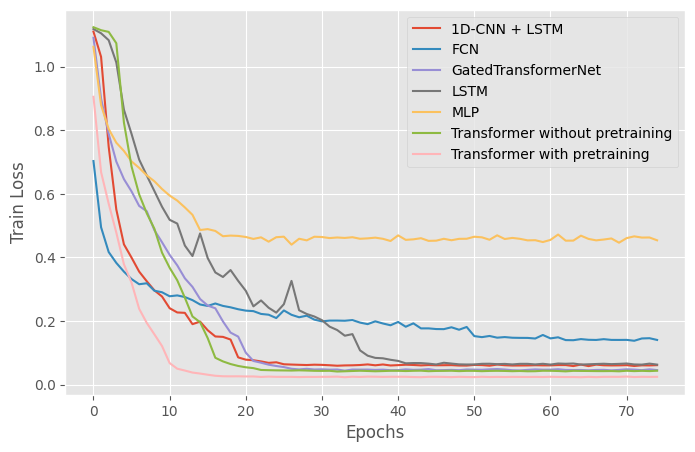

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(state_cnn_lstm["train_loss"], label="1D-CNN + LSTM")
plt.plot(state_fcn["train_loss"], label="FCN")
plt.plot(state_gated_transformer["train_loss"], label="GatedTransformerNet")
plt.plot(state_lstm["train_loss"], label="LSTM")
plt.plot(state_mlp["train_loss"], label="MLP")
plt.plot(state_transformer_supervided["train_loss"], label="Transformer without pretraining")
plt.plot(state_transformer_unsupervised["train_loss"], label="Transformer with pretraining")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.legend(loc="best")
plt.show()

## Validation Loss

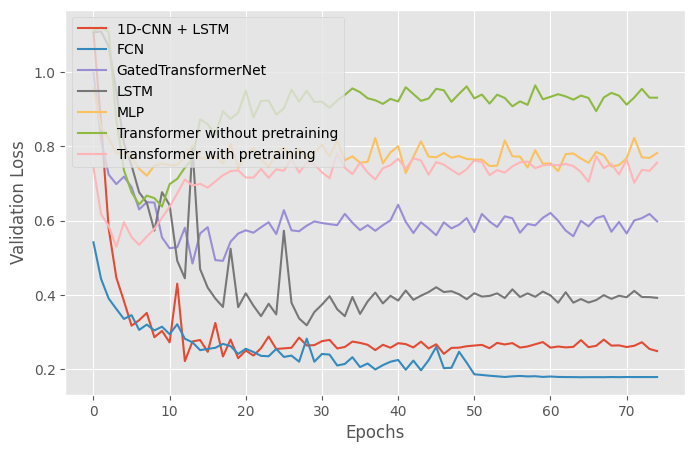

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(state_cnn_lstm["val_loss"], label="1D-CNN + LSTM")
plt.plot(state_fcn["val_loss"], label="FCN")
plt.plot(state_gated_transformer["val_loss"], label="GatedTransformerNet")
plt.plot(state_lstm["val_loss"], label="LSTM")
plt.plot(state_mlp["val_loss"], label="MLP")
plt.plot(state_transformer_supervided["val_loss"], label="Transformer without pretraining")
plt.plot(state_transformer_unsupervised["val_loss"], label="Transformer with pretraining")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")


plt.legend(loc="best")
plt.show()

## Validation Accuracy 

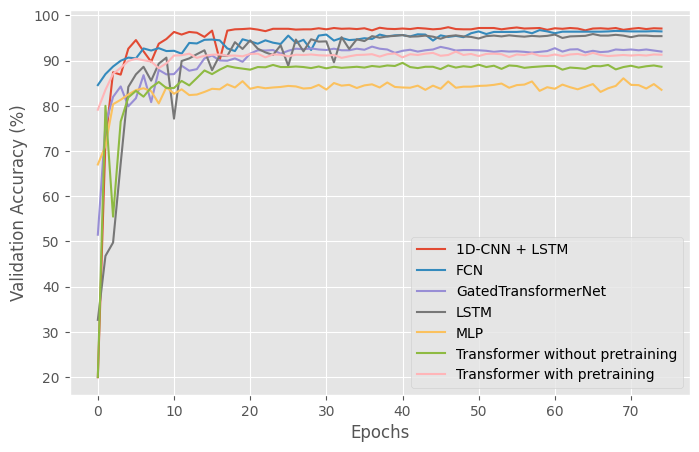

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(list(map(lambda x: x*100, state_cnn_lstm["val_acc"])), label="1D-CNN + LSTM")
plt.plot(list(map(lambda x: x*100, state_fcn["val_acc"])), label="FCN")
plt.plot(list(map(lambda x: x*100, state_gated_transformer["val_acc"])), label="GatedTransformerNet")
plt.plot(list(map(lambda x: x*100, state_lstm["val_acc"])), label="LSTM")
plt.plot(list(map(lambda x: x*100, state_mlp["val_acc"])), label="MLP")
plt.plot(list(map(lambda x: x*100, state_transformer_supervided["val_acc"])), label="Transformer without pretraining")
plt.plot(list(map(lambda x: x*100, state_transformer_unsupervised["val_acc"])), label="Transformer with pretraining")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")


plt.legend(loc="best")
plt.show()